The dataset can be downloaded here:

https://www.kaggle.com/c/dogs-vs-cats/data

In [56]:
import os
import glob
import shutil
from functools import partial

from progressbar import ProgressBar
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras

In [36]:
INP_TRAIN_DIR = "data/download/train"
INP_TEST_DIR = "data/download/test1"

DATASET_DIR = "data/dataset_"

MODEL_DIR = "data/models_"

In [8]:
train_dog_files = glob.glob(os.path.join(INP_TRAIN_DIR, "dog*.jpg"))
train_cat_files = glob.glob(os.path.join(INP_TRAIN_DIR, "cat*.jpg"))

np.random.seed(1)
np.random.shuffle(train_dog_files)
np.random.shuffle(train_cat_files)


test_files = glob.glob(os.path.join(INP_TEST_DIR, "*.jpg"))

len(train_dog_files), len(train_cat_files), len(test_files)

(12500, 12500, 12500)

In [9]:
train_dog_files[:5]

['data/download/train/dog.1094.jpg',
 'data/download/train/dog.10705.jpg',
 'data/download/train/dog.784.jpg',
 'data/download/train/dog.669.jpg',
 'data/download/train/dog.1588.jpg']

In [10]:
train_cat_files[:5]

['data/download/train/cat.5044.jpg',
 'data/download/train/cat.6924.jpg',
 'data/download/train/cat.3709.jpg',
 'data/download/train/cat.5157.jpg',
 'data/download/train/cat.9790.jpg']

In [11]:
test_files[:5]

['data/download/test1/10447.jpg',
 'data/download/test1/3337.jpg',
 'data/download/test1/7556.jpg',
 'data/download/test1/5646.jpg',
 'data/download/test1/10264.jpg']

Since the true labels for test set are not available from Kaggle page, we will split the original train set into `train`, `validation` and `test` sets.

In [13]:
TRAIN_SIZE = 20_000
VAL_SIZE = 2500
TEST_SIZE = 2500

TRAIN_SIZE_HALF = TRAIN_SIZE // 2
VAL_SIZE_HALF = VAL_SIZE // 2
TEST_SIZE_HALF = TEST_SIZE // 2

In [14]:
train_dir = os.path.join(DATASET_DIR, "train")
valid_dir = os.path.join(DATASET_DIR, "validation")
test_dir = os.path.join(DATASET_DIR, "test")

train_cats_dir = os.path.join(train_dir, "cats")
train_dogs_dir = os.path.join(train_dir, "dogs")
os.makedirs(train_cats_dir, exist_ok=True)
os.makedirs(train_dogs_dir, exist_ok=True)

valid_cats_dir = os.path.join(valid_dir, "cats")
valid_dogs_dir = os.path.join(valid_dir, "dogs")
os.makedirs(valid_cats_dir, exist_ok=True)
os.makedirs(valid_dogs_dir, exist_ok=True)

test_cats_dir = os.path.join(test_dir, "cats")
test_dogs_dir = os.path.join(test_dir, "dogs")
os.makedirs(test_cats_dir, exist_ok=True)
os.makedirs(test_dogs_dir, exist_ok=True)

In [16]:
# copy files for train/dogs and train/cats
for src in train_dog_files[: TRAIN_SIZE_HALF]:
    fname = os.path.basename(src)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
for src in train_cat_files[: TRAIN_SIZE_HALF]:
    fname = os.path.basename(src)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

In [18]:
# copy files for validation/dogs and validation/cats
for src in train_dog_files[TRAIN_SIZE_HALF: TRAIN_SIZE_HALF + VAL_SIZE_HALF]:
    fname = os.path.basename(src)
    dst = os.path.join(valid_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
for src in train_cat_files[TRAIN_SIZE_HALF: TRAIN_SIZE_HALF + VAL_SIZE_HALF]:
    fname = os.path.basename(src)
    dst = os.path.join(valid_cats_dir, fname)
    shutil.copyfile(src, dst)

In [19]:
# copy files for test/dogs and test/cats
for src in train_dog_files[TRAIN_SIZE_HALF + VAL_SIZE_HALF: ]:
    fname = os.path.basename(src)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
for src in train_cat_files[TRAIN_SIZE_HALF + VAL_SIZE_HALF: ]:
    fname = os.path.basename(src)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)

In [20]:
train_files = glob.glob(os.path.join(train_dogs_dir, "*.jpg"))
train_files += glob.glob(os.path.join(train_cats_dir, "*.jpg"))
len(train_files)

20000

In [22]:
# hights and widths
heights = []
widths = []
for fname in train_files:
    img = keras.preprocessing.image.load_img(fname)
    h, w, _ = keras.preprocessing.image.img_to_array(img).shape
    heights.append(h)
    widths.append(w)

In [23]:
np.min(heights), np.max(heights), np.mean(heights), np.median(heights)

(32, 768, 360.46485, 374.0)

In [24]:
np.min(widths), np.max(widths), np.mean(widths), np.median(widths)

(42, 1050, 403.9402, 447.0)

In [79]:
#HEIGHT, WIDTH = 360, 400

HEIGHT, WIDTH = 300, 300

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 50

train_generator = datagen.flow_from_directory(train_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

valid_generator = datagen.flow_from_directory(valid_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

test_generator = datagen.flow_from_directory(test_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [27]:
example = next(iter(train_generator))

In [29]:
# figures in first batch
example[0].shape

(50, 360, 400, 3)

In [30]:
# labels in first batch
example[1].shape

(50,)

In [31]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

# Model 1

In [34]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(HEIGHT, WIDTH, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(256, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 46, 128)       1

In [35]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.RMSprop(lr=1e-4), 
              metrics=["acc"])

In [40]:
model_file = os.path.join(MODEL_DIR, "dogcat_model_01.h5")

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#chkp_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=TRAIN_SIZE // batch_size, 
                              epochs=100,
                              validation_data=valid_generator, 
                              validation_steps=VAL_SIZE // batch_size,
                              callbacks=[early_stopping_cb])

model.save(model_file)

Epoch 1/100
400/400 [==============================] - 126s 315ms/step - loss: 0.5619 - acc: 0.7053 - val_loss: 0.5134 - val_acc: 0.7504
Epoch 2/100
400/400 [==============================] - 126s 315ms/step - loss: 0.4830 - acc: 0.7678 - val_loss: 0.4664 - val_acc: 0.7876
Epoch 3/100
400/400 [==============================] - 126s 316ms/step - loss: 0.4290 - acc: 0.7990 - val_loss: 0.4637 - val_acc: 0.7868
Epoch 4/100
400/400 [==============================] - 126s 316ms/step - loss: 0.3925 - acc: 0.8242 - val_loss: 0.4078 - val_acc: 0.8236
Epoch 5/100
400/400 [==============================] - 126s 316ms/step - loss: 0.3598 - acc: 0.8382 - val_loss: 0.3768 - val_acc: 0.8400
Epoch 6/100
400/400 [==============================] - 126s 316ms/step - loss: 0.3345 - acc: 0.8518 - val_loss: 0.3839 - val_acc: 0.8300
Epoch 7/100
400/400 [==============================] - 126s 316ms/step - loss: 0.3072 - acc: 0.8658 - val_loss: 0.3665 - val_acc: 0.8392
Epoch 8/100
400/400 [====================

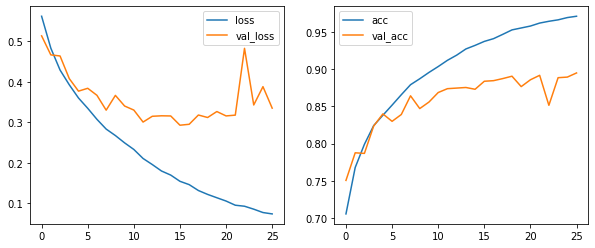

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history["loss"], label="loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()

ax[1].plot(history.history["acc"], label="acc")
ax[1].plot(history.history["val_acc"], label="val_acc")
ax[1].legend()

In [46]:
_, acc_train = model.evaluate(train_generator, steps=TRAIN_SIZE // batch_size, verbose=0)
print("Train acc: %0.4f" %acc_train)


_, acc_val = model.evaluate(valid_generator, steps=VAL_SIZE // batch_size, verbose=0)
print("Validation acc: %0.4f" %acc_val)


_, acc_test = model.evaluate(test_generator, steps=TEST_SIZE // batch_size, verbose=0)
print("Test acc: %0.4f" %acc_test)

Train acc: 0.9704
Validation acc: 0.8840
Test acc: 0.8836


# Data augmentation

by random rotation, shifting, shearing and zooming.

In [47]:
tf.random.set_seed(42)
np.random.seed(42)

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=40,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 50

train_generator = train_datagen.flow_from_directory(train_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

valid_generator = test_datagen.flow_from_directory(valid_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [48]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(HEIGHT, WIDTH, 3)))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Conv2D(256, (3, 3), activation="relu"))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 358, 398, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 179, 199, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 177, 197, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 88, 98, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 96, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 43, 48, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 46, 128)       1

In [49]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.RMSprop(lr=1e-4), 
              metrics=["acc"])


model_file = os.path.join(MODEL_DIR, "dogcat_model_01_aug.h5")

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#chkp_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=TRAIN_SIZE // batch_size, 
                              epochs=100,
                              validation_data=valid_generator, 
                              validation_steps=VAL_SIZE // batch_size,
                              callbacks=[early_stopping_cb])

model.save(model_file)

Epoch 1/100
400/400 [==============================] - 651s 2s/step - loss: 0.6475 - acc: 0.6095 - val_loss: 0.5617 - val_acc: 0.7180
Epoch 2/100
400/400 [==============================] - 651s 2s/step - loss: 0.5826 - acc: 0.6870 - val_loss: 0.5345 - val_acc: 0.7228
Epoch 3/100
400/400 [==============================] - 651s 2s/step - loss: 0.5525 - acc: 0.7165 - val_loss: 0.4944 - val_acc: 0.7596
Epoch 4/100
400/400 [==============================] - 650s 2s/step - loss: 0.5296 - acc: 0.7336 - val_loss: 0.5157 - val_acc: 0.7372
Epoch 5/100
400/400 [==============================] - 651s 2s/step - loss: 0.5119 - acc: 0.7506 - val_loss: 0.4635 - val_acc: 0.7812
Epoch 6/100
400/400 [==============================] - 650s 2s/step - loss: 0.4976 - acc: 0.7567 - val_loss: 0.4457 - val_acc: 0.7824
Epoch 7/100
400/400 [==============================] - 650s 2s/step - loss: 0.4766 - acc: 0.7701 - val_loss: 0.4896 - val_acc: 0.7728
Epoch 8/100
400/400 [==============================] - 650s 2s

Epoch 62/100
400/400 [==============================] - 651s 2s/step - loss: 0.2025 - acc: 0.9190 - val_loss: 0.1901 - val_acc: 0.9244
Epoch 63/100
400/400 [==============================] - 651s 2s/step - loss: 0.2020 - acc: 0.9172 - val_loss: 0.1543 - val_acc: 0.9416
Epoch 64/100
400/400 [==============================] - 651s 2s/step - loss: 0.1978 - acc: 0.9200 - val_loss: 0.2509 - val_acc: 0.9088
Epoch 65/100
400/400 [==============================] - 652s 2s/step - loss: 0.1963 - acc: 0.9208 - val_loss: 0.1589 - val_acc: 0.9428
Epoch 66/100
400/400 [==============================] - 652s 2s/step - loss: 0.1979 - acc: 0.9204 - val_loss: 0.1732 - val_acc: 0.9364
Epoch 67/100
400/400 [==============================] - 651s 2s/step - loss: 0.1968 - acc: 0.9210 - val_loss: 0.1599 - val_acc: 0.9468
Epoch 68/100
400/400 [==============================] - 652s 2s/step - loss: 0.2004 - acc: 0.9176 - val_loss: 0.1444 - val_acc: 0.9448
Epoch 69/100
400/400 [==============================] -

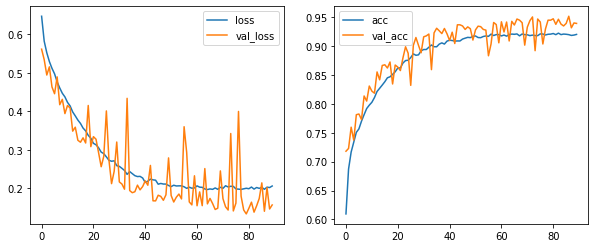

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(history.history["loss"], label="loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].legend()

ax[1].plot(history.history["acc"], label="acc")
ax[1].plot(history.history["val_acc"], label="val_acc")
ax[1].legend()

In [52]:
_, acc_train = model.evaluate(train_generator, steps=TRAIN_SIZE // batch_size, verbose=0)
print("Train acc: %0.4f" %acc_train)


_, acc_val = model.evaluate(valid_generator, steps=VAL_SIZE // batch_size, verbose=0)
print("Validation acc: %0.4f" %acc_val)


_, acc_test = model.evaluate(test_generator, steps=TEST_SIZE // batch_size, verbose=0)
print("Test acc: %0.4f" %acc_test)

Train acc: 0.9435
Validation acc: 0.9448
Test acc: 0.9496


# ResNet 34
Also use data augmentation here.

In [80]:
tf.random.set_seed(321)
np.random.seed(591)

train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=40,
                                                            width_shift_range=0.2,
                                                            height_shift_range=0.2,
                                                            shear_range=0.2,
                                                            zoom_range=0.2,
                                                            horizontal_flip=True)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

batch_size = 50

train_generator = train_datagen.flow_from_directory(train_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

valid_generator = test_datagen.flow_from_directory(valid_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                              target_size=(HEIGHT, WIDTH),
                                              classes=["cats", "dogs"], 
                                              class_mode="binary",
                                              batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [81]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        
        self._activation = keras.activations.get(activation)
        self._main_layers = []
        self._main_layers.append(DefaultConv2D(filters, strides=strides))
        self._main_layers.append(keras.layers.BatchNormalization())
        self._main_layers.append(self._activation)
        self._main_layers.append(DefaultConv2D(filters))
        self._main_layers.append(keras.layers.BatchNormalization())
        
        self._skip_layers = []
        # if strides > 1, the spatial dim (w, h) of the output is smaller than that of input 
        if strides > 1:
            self._skip_layers.append(DefaultConv2D(filters, kernel_size=1, strides=strides))
            self._skip_layers.append(keras.layers.BatchNormalization())
    
    def call(self, inputs):
        Z = inputs
        
        for layer in self._main_layers:
            Z = layer(Z)
        
        skip_Z = inputs
        for layer in self._skip_layers:
            skip_Z = layer(skip_Z)
        return self._activation(Z + skip_Z)


In [82]:
filters_list = [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3
len(filters_list)

16

In [83]:
filters_list

[64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512]

In [84]:
keras.backend.clear_session()
tf.random.set_seed(320)
np.random.seed(439)

model = keras.models.Sequential()
model.add(DefaultConv2D(filters=64, kernel_size=7, strides=2, input_shape=(HEIGHT, WIDTH, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters = 64
for filters in filters_list:
    if filters == prev_filters:
        strides = 1
    else:
        strides = 2
    
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 75, 75, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 75, 75, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 75, 75, 64)        7

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.RMSprop(lr=1e-4), 
              metrics=["acc"])


model_file = os.path.join(MODEL_DIR, "dogcat_resnet34_aug.h5")

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#chkp_cb = keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=TRAIN_SIZE // batch_size, 
                              epochs=100,
                              validation_data=valid_generator, 
                              validation_steps=VAL_SIZE // batch_size,
                              callbacks=[early_stopping_cb])

model.save(model_file)

Epoch 1/100
400/400 [==============================] - 441s 1s/step - loss: 0.6565 - acc: 0.6313 - val_loss: 0.8370 - val_acc: 0.5408
Epoch 2/100
234/400 [================>.............] - ETA: 3:01 - loss: 0.5636 - acc: 0.7110